# Setup

In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib_venn import venn3, venn2
import random
import plotly.io as pio
from scipy import sparse
import os
import networkx as nx

In [101]:
seed = 16
random.seed(seed)
np.random.seed(seed)

#esto es para forzar a plt a poner fondos blancos en las figuras aunque el tema del notebook sea oscuro
#plt.rcParams['axes.facecolor'] = 'white'
#plt.rcParams['figure.facecolor'] = 'white'
cmap = plt.get_cmap("tab10")
pio.templates.default = "seaborn"

sns.set_style("darkgrid", rc={'xtick.bottom': True})

In [102]:
data_processed = "../../../data/processed/"
data_interim = "../../../data/interim/"
data_external = "../../../data/external/"
tfidf_reports = "../../../reports/tfidf/"
reports_comunidades = "../../../reports/analisis_comunidades/"
reports_jaccard = "../../../reports/jaccard_gene_similarity/"

In [103]:
def get_node_dict(G):
    return {node:data for (node,data) in list(G.nodes(data=True))}

def node_labels_to_numeric(G):
    new_labels = {old_label:int(old_label) for old_label in list(G.nodes)}
    nx.relabel_nodes(G,new_labels,False)

In [104]:
graph_node_data = pd.read_csv(data_processed+"graph_data/grafo_alternativo_CG_nodos.csv")
G = nx.read_gml(data_processed+"graph_data/gda_network.gml")
node_labels_to_numeric(G)

nodos_gda = pd.DataFrame(get_node_dict(G)).T.reset_index().rename(columns={"index":"node_index"})
nodos_enfermedad = nodos_gda.loc[nodos_gda.node_type == "disease", "node_index"].values

In [105]:
nodos_gda

,node_index,node_type,node_name,node_id,node_source
0,33368,disease,PERRAULT SYNDROME 6,C4479656,disgenet
1,11771,gene_protein,PDGFC,56034,disgenet
2,19156,disease,Dry Eye Syndromes,C0013238,disgenet
3,24192,disease,Acrodermatitis continua of Hallopeau,C0392439,disgenet
4,22295,disease,Fine Tremor,C0234373,disgenet
...,...,...,...,...,...
20851,32900,disease,Hyperinsulinism due to HNF4A deficiency,C4274078,disgenet
20852,10565,gene_protein,PLTP,5360,disgenet
20853,24318,disease,Primary immune deficiency disorder,C0398686,disgenet
20854,32,gene_protein,MIR875,100126309,disgenet


# Jaccard de genes compartidos

Ver para clusters asociados con cancer. Ver para casos no nulos (dirección inversa).

In [106]:
def jaccard(set1,set2):
    intersection = len(set1&set2)
    union = len(set1|set2)
    return round(intersection/union,2)

In [107]:
conjuntos_enfermedad = {}

for enfermedad in nodos_enfermedad:
    vecinos = list(G.neighbors(enfermedad))
    conjuntos_enfermedad[enfermedad] = set(vecinos)

In [108]:
matrix_jaccard = np.zeros((len(nodos_enfermedad), len(nodos_enfermedad)))

In [109]:
for i in range(len(nodos_enfermedad)):
    for j in range(len(nodos_enfermedad)):
        nodo_i = nodos_enfermedad[i]
        nodo_j = nodos_enfermedad[j]
        conjunto_i = conjuntos_enfermedad[nodo_i]
        conjunto_j = conjuntos_enfermedad[nodo_j]
        coef = jaccard(conjunto_i, conjunto_j)
        matrix_jaccard[i,j] = coef

In [112]:
sparse_jaccard = sparse.csr_matrix(matrix_jaccard)
# sparse.save_npz(reports_jaccard+"jaccard_sparse_matrix.npz",sparse_jaccard)
df_jaccard_sparse = pd.DataFrame.sparse.from_spmatrix(sparse_jaccard, index=nodos_enfermedad, columns=nodos_enfermedad)

# Similaridad jaccard vs comunidades

## Checkpoint

In [120]:
sparse_jaccard = sparse.load_npz(reports_jaccard+"jaccard_sparse_matrix_2.npz")
df_jaccard_sparse = pd.DataFrame.sparse.from_spmatrix(sparse_jaccard, index=nodos_enfermedad, columns=nodos_enfermedad)

In [121]:
df_jaccard_sparse

,33368,19156,24192,22295,31097,29354,30437,19168,26882,19094,...,27780,18853,33170,25712,28276,19898,26204,32900,24318,33386
33368,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19156,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24192,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22295,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31097,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
26204,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03,...,0.0,0.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
32900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
24318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [132]:
no_nulos = (sparse_jaccard.nnz - 11167)/2
print(no_nulos)

710168.0


In [9]:
graph_node_data = pd.read_csv(data_processed+"graph_data/grafo_alternativo_CG_nodos.csv")
disease_attributes = pd.read_csv(data_interim+"grafo_alternativo_disease_attributes.csv")

nodos_bert = graph_node_data.loc[graph_node_data.node_type == "bert_group",["node_index","node_id","node_name","node_source"]].copy()
disease_attributes = pd.concat([disease_attributes,nodos_bert])

enfermedades_en_dd = graph_node_data.loc[graph_node_data.degree_dd != 0, "node_index"].values
disease_attributes = disease_attributes.set_index("node_index").loc[enfermedades_en_dd].reset_index()

disease_attributes = pd.merge(graph_node_data[["node_index","comunidades_infomap","comunidades_louvain"]],disease_attributes,left_on="node_index",right_on="node_index",how="right")

tamaños_louvain = disease_attributes.comunidades_louvain.value_counts()
tamaños_infomap = disease_attributes.comunidades_infomap.value_counts()

infomap_clusters = pd.DataFrame(tamaños_infomap).reset_index().rename(columns={"index":"comunidad","comunidades_infomap":"tamaño"}).astype({"comunidad":"int"})
louvain_clusters = pd.DataFrame(tamaños_louvain).reset_index().rename(columns={"index":"comunidad","comunidades_louvain":"tamaño"}).astype({"comunidad":"int"})

In [9]:
infomap_clusters

,comunidad,tamaño
0,3,198
1,354,82
2,188,74
3,416,74
4,436,71
...,...,...
1136,968,2
1137,1060,2
1138,1010,2
1139,1121,2


Ver cantidad de enlaces GDA por comunidad. Puede ser la fracción de enfermedades con mapeo. Con las dos particiones.

De los que tienen enlaces, ver el numero medio de enlaces. 

Reportar las dos cosas.

In [11]:
graph_node_data

,node_index,node_id,node_name,node_type,node_source,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd
0,0,1,A1BG,gene_protein,disgenet,NaN,NaN,2.0,12.0,0.0
1,1,10,NAT2,gene_protein,disgenet,NaN,NaN,39.0,6.0,0.0
2,2,100,ADA,gene_protein,disgenet,NaN,NaN,18.0,5.0,0.0
3,3,1000,CDH2,gene_protein,disgenet,NaN,NaN,28.0,15.0,0.0
4,4,10000,AKT3,gene_protein,disgenet,NaN,NaN,9.0,39.0,0.0
...,...,...,...,...,...,...,...,...,...,...
35864,36633,SIGNOR-C93,MYOD1/SWI/SNF complex,complex,signor,NaN,NaN,0.0,2.0,0.0
35865,36634,SIGNOR-C94,Myog/SWI/SNF complex,complex,signor,NaN,NaN,0.0,2.0,0.0
35866,36635,SIGNOR-C95,CDON/BOC/PTCH1,complex,signor,NaN,NaN,0.0,3.0,0.0
35867,36636,SIGNOR-C97,RBPJ/NOTCH,complex,signor,NaN,NaN,0.0,2.0,0.0


In [17]:
algoritmo = "comunidades_infomap"
cluster = 5
similarity_matrix = df_jaccard_sparse

nodos_cluster = graph_node_data[graph_node_data[algoritmo] == cluster].node_index.values
nodos_disponibles = list(set(nodos_cluster)&set(nodos_enfermedad))
cluster_matrix = similarity_matrix.loc[nodos_disponibles,nodos_disponibles].values

In [136]:
def mean_similarity_triu(similarity_matrix, cluster, algoritmo):
    nodos_cluster = graph_node_data[graph_node_data[algoritmo] == cluster].node_index.values
    nodos_disponibles = list(set(nodos_cluster)&set(nodos_enfermedad))
    cluster_matrix = similarity_matrix.loc[nodos_disponibles,nodos_disponibles].values
    indices = np.triu_indices_from(cluster_matrix,1)
    values = cluster_matrix[indices]
    return round(np.mean(values), 2)

In [137]:
infomap_similarity = pd.Series({cluster:mean_similarity_triu(df_jaccard_sparse, cluster, "comunidades_infomap") for cluster in infomap_clusters.comunidad.values}, name="jaccard_mean_similarity")
louvain_similarity = pd.Series({cluster:mean_similarity_triu(df_jaccard_sparse, cluster, "comunidades_louvain") for cluster in louvain_clusters.comunidad.values}, name="jaccard_mean_similarity")

infomap_clusters = pd.merge(infomap_clusters,infomap_similarity, left_on="comunidad",right_index=True)
louvain_clusters = pd.merge(louvain_clusters,louvain_similarity, left_on="comunidad",right_index=True)

/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ingrid/.local/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = 

Text(0.5, 1.0, 'Louvain')

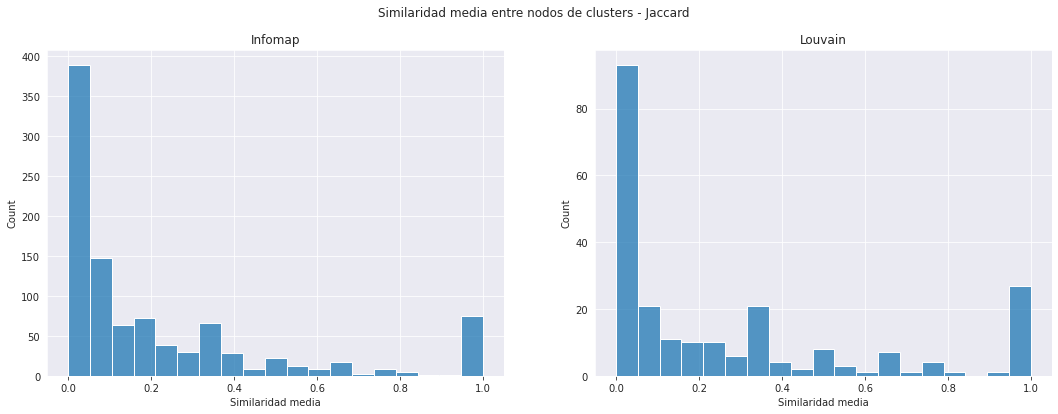

In [138]:
fig, ax = plt.subplots(1,2,figsize=(18,6))
fig.suptitle(f"Similaridad media entre nodos de clusters - Jaccard")

sns.histplot(data=infomap_clusters["jaccard_mean_similarity"], ax=ax[0], bins=np.linspace(0,1,20))
ax[0].set_xlabel("Similaridad media")
ax[0].set_title("Infomap")

sns.histplot(data=louvain_clusters["jaccard_mean_similarity"], ax=ax[1],bins=np.linspace(0,1,20))
ax[1].set_xlabel("Similaridad media")
ax[1].set_title("Louvain")

# Veo clusters específicos

In [27]:
infomap_cluster_data = pd.read_pickle("../../../reports/tfidf/infomap_analysis_checkpoint.pkl")
louvain_cluster_data = pd.read_pickle("../../../reports/tfidf/louvain_analysis_checkpoint.pkl")

In [36]:
conectividad_infomap = pd.read_csv(reports_comunidades+"grado_gda_infomap.csv")
conectividad_louvain = pd.read_csv(reports_comunidades+"grado_gda_louvain.csv")

In [34]:
infomap_cluster_data[infomap_cluster_data.top_5_monograms.apply(lambda x: "cancer" in x)]

,comunidad,tamaño,mean_similarity_mono,mean_similarity_bi,mean_similarity_tri,entropia_1,entropia_2,entropia_3,top_monogram,top_monogram_score,...,top_5_monograms,top_5_bigrams,top_5_trigrams,top_5_monograms_score,top_5_bigrams_score,top_5_trigrams_score,mean_similarity_mono_triu,mean_similarity_bi_triu,mean_similarity_tri_triu,pvalor
212,242,16,0.15,0.10,0.11,0.61,0.53,0.43,melanoma,0.28,...,"[melanoma, tumor, cancer, predisposition, heal]","[self heal, rare inherit, cancer predispose, s...","[inherit cancer predispose, cancer characteriz...","[0.28, 0.26, 0.24, 0.24, 0.23]","[0.29, 0.19, 0.19, 0.19, 0.18]","[0.37, 0.33, 0.31, 0.29, 0.22]",0.09,0.04,0.05,0.0
253,6,15,0.65,0.36,0.25,0.35,0.34,0.26,prostate,0.89,...,"[prostate, carcinoma, cancer, familial, heredi...","[prostate cancer, prostate carcinoma, cancer h...","[cancer cause mutation, relative patient histo...","[0.89, 0.23, 0.22, 0.12, 0.11]","[0.69, 0.42, 0.3, 0.18, 0.14]","[0.47, 0.35, 0.35, 0.35, 0.35]",0.63,0.32,0.20,0.0
255,16,15,0.42,0.18,0.12,0.44,0.42,0.35,breast,0.79,...,"[breast, carcinoma, cancer, tumor, brca1]","[breast carcinoma, breast cancer, arises breas...","[breast carcinoma carcinoma, malignant tumor a...","[0.79, 0.36, 0.19, 0.14, 0.14]","[0.57, 0.49, 0.16, 0.15, 0.15]","[0.37, 0.28, 0.28, 0.27, 0.27]",0.38,0.12,0.07,0.0
382,101,11,0.32,0.13,0.11,0.50,0.47,0.39,vulva,0.66,...,"[vulva, vulvar, li, melanoma, cancer]","[affect vulva, vulvar cancer, lichen sclerosus...","[chronic inflammatory unknown, inflammatory un...","[0.66, 0.54, 0.16, 0.16, 0.12]","[0.44, 0.27, 0.22, 0.2, 0.15]","[0.33, 0.3, 0.3, 0.26, 0.22]",0.25,0.05,0.03,0.0
482,585,9,0.88,0.84,0.79,0.22,0.21,0.13,ovarian,0.59,...,"[ovarian, breast, cancer, susceptibility, fami...","[ovarian cancer, familial susceptibility, canc...","[cancer cause mutation, cause mutation brca1, ...","[0.59, 0.54, 0.39, 0.27, 0.21]","[0.63, 0.42, 0.37, 0.35, 0.32]","[0.84, 0.32, 0.31, 0.31, 0.0]",0.86,0.82,0.77,0.0
513,680,9,0.67,0.54,0.50,0.44,0.42,0.28,colorectal,0.42,...,"[colorectal, cancer, nonpolyposis, carcinoma, ...","[hereditary nonpolyposis, colon cancer, early ...","[epithelial tumor ovary, condition characteriz...","[0.42, 0.41, 0.33, 0.32, 0.26]","[0.39, 0.29, 0.24, 0.22, 0.2]","[0.42, 0.42, 0.36, 0.3, 0.3]",0.63,0.49,0.45,0.0
643,29,7,0.43,0.22,0.17,0.47,0.40,0.31,bladder,0.76,...,"[bladder, carcinoma, squamous, cancer, urinary]","[carcinoma bladder, cell carcinoma, squamous c...","[cell carcinoma bladder, squamous cell carcino...","[0.76, 0.43, 0.16, 0.13, 0.12]","[0.54, 0.32, 0.26, 0.23, 0.23]","[0.58, 0.54, 0.23, 0.22, 0.21]",0.34,0.09,0.05,0.0
645,91,7,0.32,0.15,0.14,0.45,0.40,0.33,peritoneal,0.47,...,"[peritoneal, leiomyoma, cancer, smooth, benign]","[renal cell, cell cancer, smooth muscle, perit...","[smooth muscle cell, characterize formation mu...","[0.47, 0.32, 0.27, 0.24, 0.24]","[0.36, 0.36, 0.29, 0.25, 0.19]","[0.44, 0.32, 0.32, 0.32, 0.31]",0.21,0.04,0.02,0.0
720,863,6,0.89,0.86,0.84,0.17,0.18,0.10,nonpolyposis,0.80,...,"[nonpolyposis, colorectal, hereditary, cancer,...","[hereditary nonpolyposis, cancer hereditary, c...","[cancer cause mutation, gene colorectal cancer...","[0.8, 0.33, 0.31, 0.3, 0.25]","[0.72, 0.37, 0.32, 0.29, 0.28]","[0.76, 0.63, 0.16, 0.0, 0.0]",0.87,0.83,0.81,0.0
806,390,5,0.68,0.57,0.42,0.43,0.42,0.35,p53,0.36,...,"[p53, carcinoma, suppressor, li, cancer]","[tumor suppressor, suppressor gene, tissue sar...","[tumor suppressor gene, soft tissue sarcoma, a...","[0.36, 0.34, 0.31, 0.27, 0.26]","[0.33, 0.32, 0.26, 0.22, 0.19]","[0.5, 0.39, 0.22, 0.22, 0.22]",0.60,0.46,0.32,0.0


In [39]:
ejemplo = 16

In [40]:
graph_node_data[graph_node_data.comunidades_infomap == ejemplo]

,node_index,node_id,node_name,node_type,node_source,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd
18740,18818,C0007104,Female Breast Carcinoma,disease,disgenet,16.0,1.0,0.0,0.0,1.0
18751,18829,C0007125,"Carcinoma, Ehrlich Tumor",disease,disgenet,16.0,1.0,0.0,0.0,1.0
22112,22349,C0235653,Malignant neoplasm of female breast,disease,disgenet,16.0,1.0,0.0,0.0,1.0
22167,22405,C0238033,Carcinoma of Male Breast,disease,disgenet,16.0,1.0,4.0,0.0,1.0
22298,22545,C0242787,Malignant neoplasm of male breast,disease,disgenet,16.0,1.0,0.0,0.0,1.0
22299,22546,C0242788,"Breast Neoplasms, Male",disease,disgenet,16.0,1.0,4.0,0.0,1.0
23154,23474,C0281267,bilateral breast cancer,disease,disgenet,16.0,1.0,0.0,0.0,3.0
23665,24029,C0346153,"Breast Cancer, Familial",disease,disgenet,16.0,1.0,30.0,0.0,2.0
24604,25017,C0677776,Hereditary Breast and Ovarian Cancer Syndrome,disease,disgenet,16.0,1.0,14.0,0.0,4.0
24614,25027,C0678222,Breast Carcinoma,disease,disgenet,16.0,1.0,538.0,0.0,19.0


In [41]:
conectividad_infomap[conectividad_infomap.comunidad == ejemplo]

,comunidad,tamaño,fraccion_gda,grado_gda_medio,max_grado_gda
255,16,15,0.4,98.5,538.0


In [135]:
mean_similarity_triu(df_jaccard_sparse,16,"comunidades_infomap")

0.11

In [45]:
algoritmo = "comunidades_infomap"
cluster = ejemplo
similarity_matrix = df_jaccard_sparse

nodos_cluster = graph_node_data[graph_node_data[algoritmo] == cluster].node_index.values
nodos_disponibles = list(set(nodos_cluster)&set(nodos_enfermedad))
cluster_matrix = similarity_matrix.loc[nodos_disponibles,nodos_disponibles].values

In [62]:
nodo_1 = 24029
nodo_2 = 25017

set_1 = conjuntos_enfermedad[nodo_1]
set_2 = conjuntos_enfermedad[nodo_2]

In [63]:
round(jaccard(set_1,set_2),2)

0.29

In [71]:
matrix_jaccard_cluster = np.zeros((len(nodos_cluster), len(nodos_cluster)))
nodos_cluster = list(set(nodos_cluster)&set(nodos_enfermedad))

for i in range(len(nodos_cluster)):
    for j in range(len(nodos_cluster)):
        nodo_i = nodos_cluster[i]
        nodo_j = nodos_cluster[j]
        conjunto_i = conjuntos_enfermedad[nodo_i]
        conjunto_j = conjuntos_enfermedad[nodo_j]
        coef = jaccard(conjunto_i, conjunto_j)
        matrix_jaccard_cluster[i,j] = coef

In [76]:
indices = np.triu_indices_from(matrix_jaccard_cluster,1)
values = matrix_jaccard_cluster[indices]

In [ ]:
aver = matrix_jaccard_cluster.sparse.to

In [83]:
pd.DataFrame(matrix_jaccard_cluster, index=nodos_cluster, columns=nodos_cluster)

,25027,22405,26672,22546,25017,24029
25027,1.00,0.01,0.00,0.01,0.02,0.03
22405,0.01,1.00,0.00,1.00,0.06,0.03
26672,0.00,0.00,1.00,0.00,0.07,0.03
22546,0.01,1.00,0.00,1.00,0.06,0.03
25017,0.02,0.06,0.07,0.06,1.00,0.29
24029,0.03,0.03,0.03,0.03,0.29,1.00


In [119]:
df_jaccard_sparse.loc[nodos_cluster,nodos_cluster]

,25027,22405,26672,22546,25017,24029
25027,1.00,0.01,0.00,0.01,0.02,0.03
22405,0.01,1.00,0.00,1.00,0.06,0.03
26672,0.00,0.00,1.00,0.00,0.07,0.03
22546,0.01,1.00,0.00,1.00,0.06,0.03
25017,0.02,0.06,0.07,0.06,1.00,0.29
24029,0.03,0.03,0.03,0.03,0.29,1.00


In [84]:
sparse_jaccard_test = sparse.csr_matrix(matrix_jaccard_cluster)
df_jaccard_sparse_test = pd.DataFrame.sparse.from_spmatrix(sparse_jaccard_test, index=nodos_cluster, columns=nodos_cluster)

In [87]:
mean_similarity_triu(df_jaccard_sparse_test,ejemplo,"comunidades_infomap")

0.11

In [115]:
df_jaccard_sparse.loc[nodos_cluster,nodos_cluster]

,25027,22405,26672,22546,25017,24029
25027,1.00,0.01,0.00,0.01,0.02,0.03
22405,0.01,1.00,0.00,1.00,0.06,0.03
26672,0.00,0.00,1.00,0.00,0.07,0.03
22546,0.01,1.00,0.00,1.00,0.06,0.03
25017,0.02,0.06,0.07,0.06,1.00,0.29
24029,0.03,0.03,0.03,0.03,0.29,1.00
